# Packages


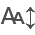

In [193]:
import plotly.express as px
import pandas as pd
from google.cloud import bigquery
import numpy as np
from datetime import time, timedelta, datetime
import math 
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as st
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import os
import ipywidgets
import statsmodels.stats.weightstats as sw
from statsmodels.stats.proportion import test_proportions_2indep
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%config InlineBackend.figure_format='retina'
from google.cloud import bigquery
from scipy.stats import norm
from scipy import stats
pd.options.display.float_format = "{:,.2f}".format
from scipy.stats import norm
from scipy import stats
import statsmodels.stats.weightstats as ws
import openpyxl
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# from ambrosia.designer import Designer
import AB_library
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
# df["Week"] = df["Date"].dt.to_period("W").dt.to_timestamp()

bigquery_client = bigquery.Client(project='analytics-dev-333113')

def cycle_sql(start, end, query, weeks=False):
    """
    You have to use {date} in your script to add cycle date into this backets
    """
    date_start = datetime.strptime(start, '%Y-%m-%d')
    date_end = datetime.strptime(end, '%Y-%m-%d')

    if weeks == False:
        daterange = [(date_start + timedelta(days=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days)+1)]
    else:
        daterange = [(date_start + timedelta(weeks=x)).strftime('%Y-%m-%d') for x in range(((date_end-date_start).days//7)+1)] # weeks dividing days by 7

    total_df = pd.DataFrame()

    counter = 0

    for date in daterange:
        counter+=1
        print(f"{counter}) Uploading - {date}:", datetime.today().strftime('%Y-%m-%d %H:%M:%S'))
        script = query.format(date = date)
        df_cycle = bigquery_client.query(script).to_dataframe()
        if df_cycle.empty == True:
            print('Dataframe is empty')
        total_df = pd.concat([df_cycle, total_df])
    return total_df

def read_bq(query, project='analytics-dev-333113'):
    client = bigquery.Client(project=project)
    query_job = client.query(query)
    result_df = query_job.to_dataframe()
    return result_df

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(
        html_str.replace('table','table style="display:inline"'), 
        raw=True
    )

# Data pulling

In [220]:
df_checks = read_bq("""
WITH liveness AS (SELECT user_id,
                         os_name,
                         event_dt_part,
                         city_id,
                         city_name,
                         country_id,
                         country_name,
                         filled_flow,
                         MAX(IF(name = 'client.verification_start.click', client_time, NULL)) AS click_dt,
                         MAX(IF(name = 'client.verification_flow_change_status.done', client_time,
                                NULL))                                                        AS provide_dt,
                         MAX(IF((name = 'client.verification_flow_result_status.show' AND
                                 LOWER(status) = 'approve'), client_time,
                                NULL))                                                        AS approve_dt
                  FROM (SELECT user_id,
                               name,
                               os_name,
                               event_dt_part,
                               TIMESTAMP_MILLIS(client_time)                           AS client_time,
                               t1.city_id,
                               t2.city_name,
                               t2.country_id,
                               t2.country_name,
                               JSON_EXTRACT_SCALAR(payload, '$.verification_flow')     AS verification_flow,
                               IF(JSON_EXTRACT_SCALAR(payload, '$.verification_flow') IS NULL,
                                  LAG(JSON_EXTRACT_SCALAR(payload, '$.verification_flow'))
                                      OVER (PARTITION BY user_id, event_dt_part ORDER BY client_time),
                                  JSON_EXTRACT_SCALAR(payload, '$.verification_flow')) AS filled_flow,
                               JSON_EXTRACT_SCALAR(payload, '$.status')                AS status
                        FROM indriver-e6e40.emart.swrve_event t1
                                 JOIN indriver-e6e40.heap.vw_macroregion_mapping t2
                                      ON
                                          t1.city_id = t2.city_id
                        WHERE 1 = 1
                          AND name IN (
                                       'client.verification_start.click',
                                       'client.verification_flow_change_status.done',
                                       'client.verification_flow_result_status.show'
                            )
                          AND event_dt_part BETWEEN '2024-12-01' AND '2024-12-31'
                          AND t2.country_id IN (46, 54, 25, 12, 43, 24, 11, 22, 10, 75, 85)
                        QUALIFY ROW_NUMBER() OVER (PARTITION BY user_id, name, event_dt_part ORDER BY client_time) = 1)
                  GROUP BY 1, 2, 3, 4, 5, 6, 7, 8),
     rides AS (SELECT order_uuid,
                      user_id    AS pass_id,
                      driver_id,
                      city_id    AS order_city_id,
                      country_id AS order_country_id,
                      status_order,
                      order_timestamp,
                      at_pickup_dttm,
                      departed_pickup_dttm,
                      at_destination_dttm,
                      departed_destination_dttm,
                      driveraccept_timestamp,
                      driverarrived_timestamp,
                      driverstarttheride_timestamp,
                      driverdone_timestamp,
                      clientdone_timestamp,
                      clientcancel_timestamp,
                      drivercancel_timestamp,
                      user_reg_date,
                      driver_reg_date,
                      stage,
                      created_date_order_part,
                      duration_in_seconds
               FROM indriver-e6e40.imart.incity_detail_new_order
               WHERE created_date_order_part >= '2024-12-01'
                 AND driveraccept_timestamp IS NOT NULL
                 AND (clientcancel_timestamp IS NULL
                   AND drivercancel_timestamp IS NULL))
SELECT t1.*,
       t2.order_timestamp,
       t2.status_order,
       IF(t2.order_timestamp IS NOT NULL, 1, 0)          AS has_ride,
       DATE_DIFF(t2.order_timestamp, provide_dt, SECOND) AS date_diff_order_provide,
       DATE_DIFF(t2.order_timestamp, approve_dt, SECOND) AS date_diff_order_approve,
       DATE_DIFF(approve_dt, click_dt, SECOND)           AS date_diff_approve_click,
       DATE_DIFF(approve_dt, provide_dt, SECOND)         AS date_diff_approve_provide
FROM liveness t1
         LEFT JOIN rides t2
                   ON t1.user_id = t2.pass_id
                       AND t2.order_timestamp BETWEEN approve_dt AND DATE_ADD(approve_dt, INTERVAL + 180 MINUTE)
""")

df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_provide'].isna()].index)
df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_provide']>np.percentile(df_checks['date_diff_approve_provide'], 95)].index)
df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_provide']<0].index)

df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_click'].isna()].index)
df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_click']>np.percentile(df_checks['date_diff_approve_click'], 95)].index)
df_checks = df_checks.drop(index = df_checks[df_checks['date_diff_approve_click']<0].index)

df_checks.head()

user_id  os_name event_dt_part  city_id                   city_name  \
0   84285389  android    2024-12-06     5589                      Osorno   
3  259015412  android    2024-12-15     4250                       Pasto   
4  269706448      ios    2024-12-08     5528  Santiago de los Caballeros   
5  271475235  android    2024-12-31     4246                     Popayan   
6  272171724  android    2024-12-22      835                  Rustenburg   

   country_id        country_name filled_flow  \
0          25               Chile    liveness   
3          22            Colombia    liveness   
4          46  Dominican Republic    liveness   
5          22            Colombia    liveness   
6          10        South Africa    liveness   

                          click_dt                       provide_dt  \
0 2024-12-06 18:21:33.174000+00:00 2024-12-06 18:22:17.010000+00:00   
3 2024-12-15 02:33:17.336000+00:00 2024-12-15 02:33:49.494000+00:00   
4 2024-12-08 22:40:32.060000+00:00 2024-12-08 22:41:08.708000+00:00   
5 2024-12-31 01:26:23.219000+00:00 2024-12-31 01:27:36.076000+00:00   
6 2024-12-22 23:38:35.755000+00:00 2024-12-22 23:39:14.782000+00:00   

                        approve_dt           order_timestamp  \
0 2024-12-06 18:22:32.267000+00:00 2024-12-06 18:22:41+00:00   
3 2024-12-15 02:33:49.900000+00:00                       NaT   
4 2024-12-08 22:41:11.581000+00:00 2024-12-08 22:41:23+00:00   
5 2024-12-31 01:27:36.079000+00:00                       NaT   
6 2024-12-22 23:39:14.780000+00:00 2024-12-22 23:39:26+00:00   

       status_order  has_ride  date_diff_order_provide  \
0  RIDE_STATUS_DONE         1                       23   
3              None         0                     <NA>   
4  RIDE_STATUS_DONE         1                       14   
5              None         0                     <NA>   
6  RIDE_STATUS_DONE         1                       11   

   date_diff_order_approve  date_diff_approve_click  date_diff_approve_provide  
0                        8                       59                         15  
3                     <NA>                       32                          0  
4                       11                       39                          2  
5                     <NA>                       72                          0  
6                       11                       39                          0

In [228]:
df_checks.columns

Index(['user_id', 'os_name', 'event_dt_part', 'city_id', 'city_name',
       'country_id', 'country_name', 'filled_flow', 'click_dt', 'provide_dt',
       'approve_dt', 'order_timestamp', 'status_order', 'has_ride',
       'date_diff_order_provide', 'date_diff_order_approve',
       'date_diff_approve_click', 'date_diff_approve_provide'],
      dtype='object')

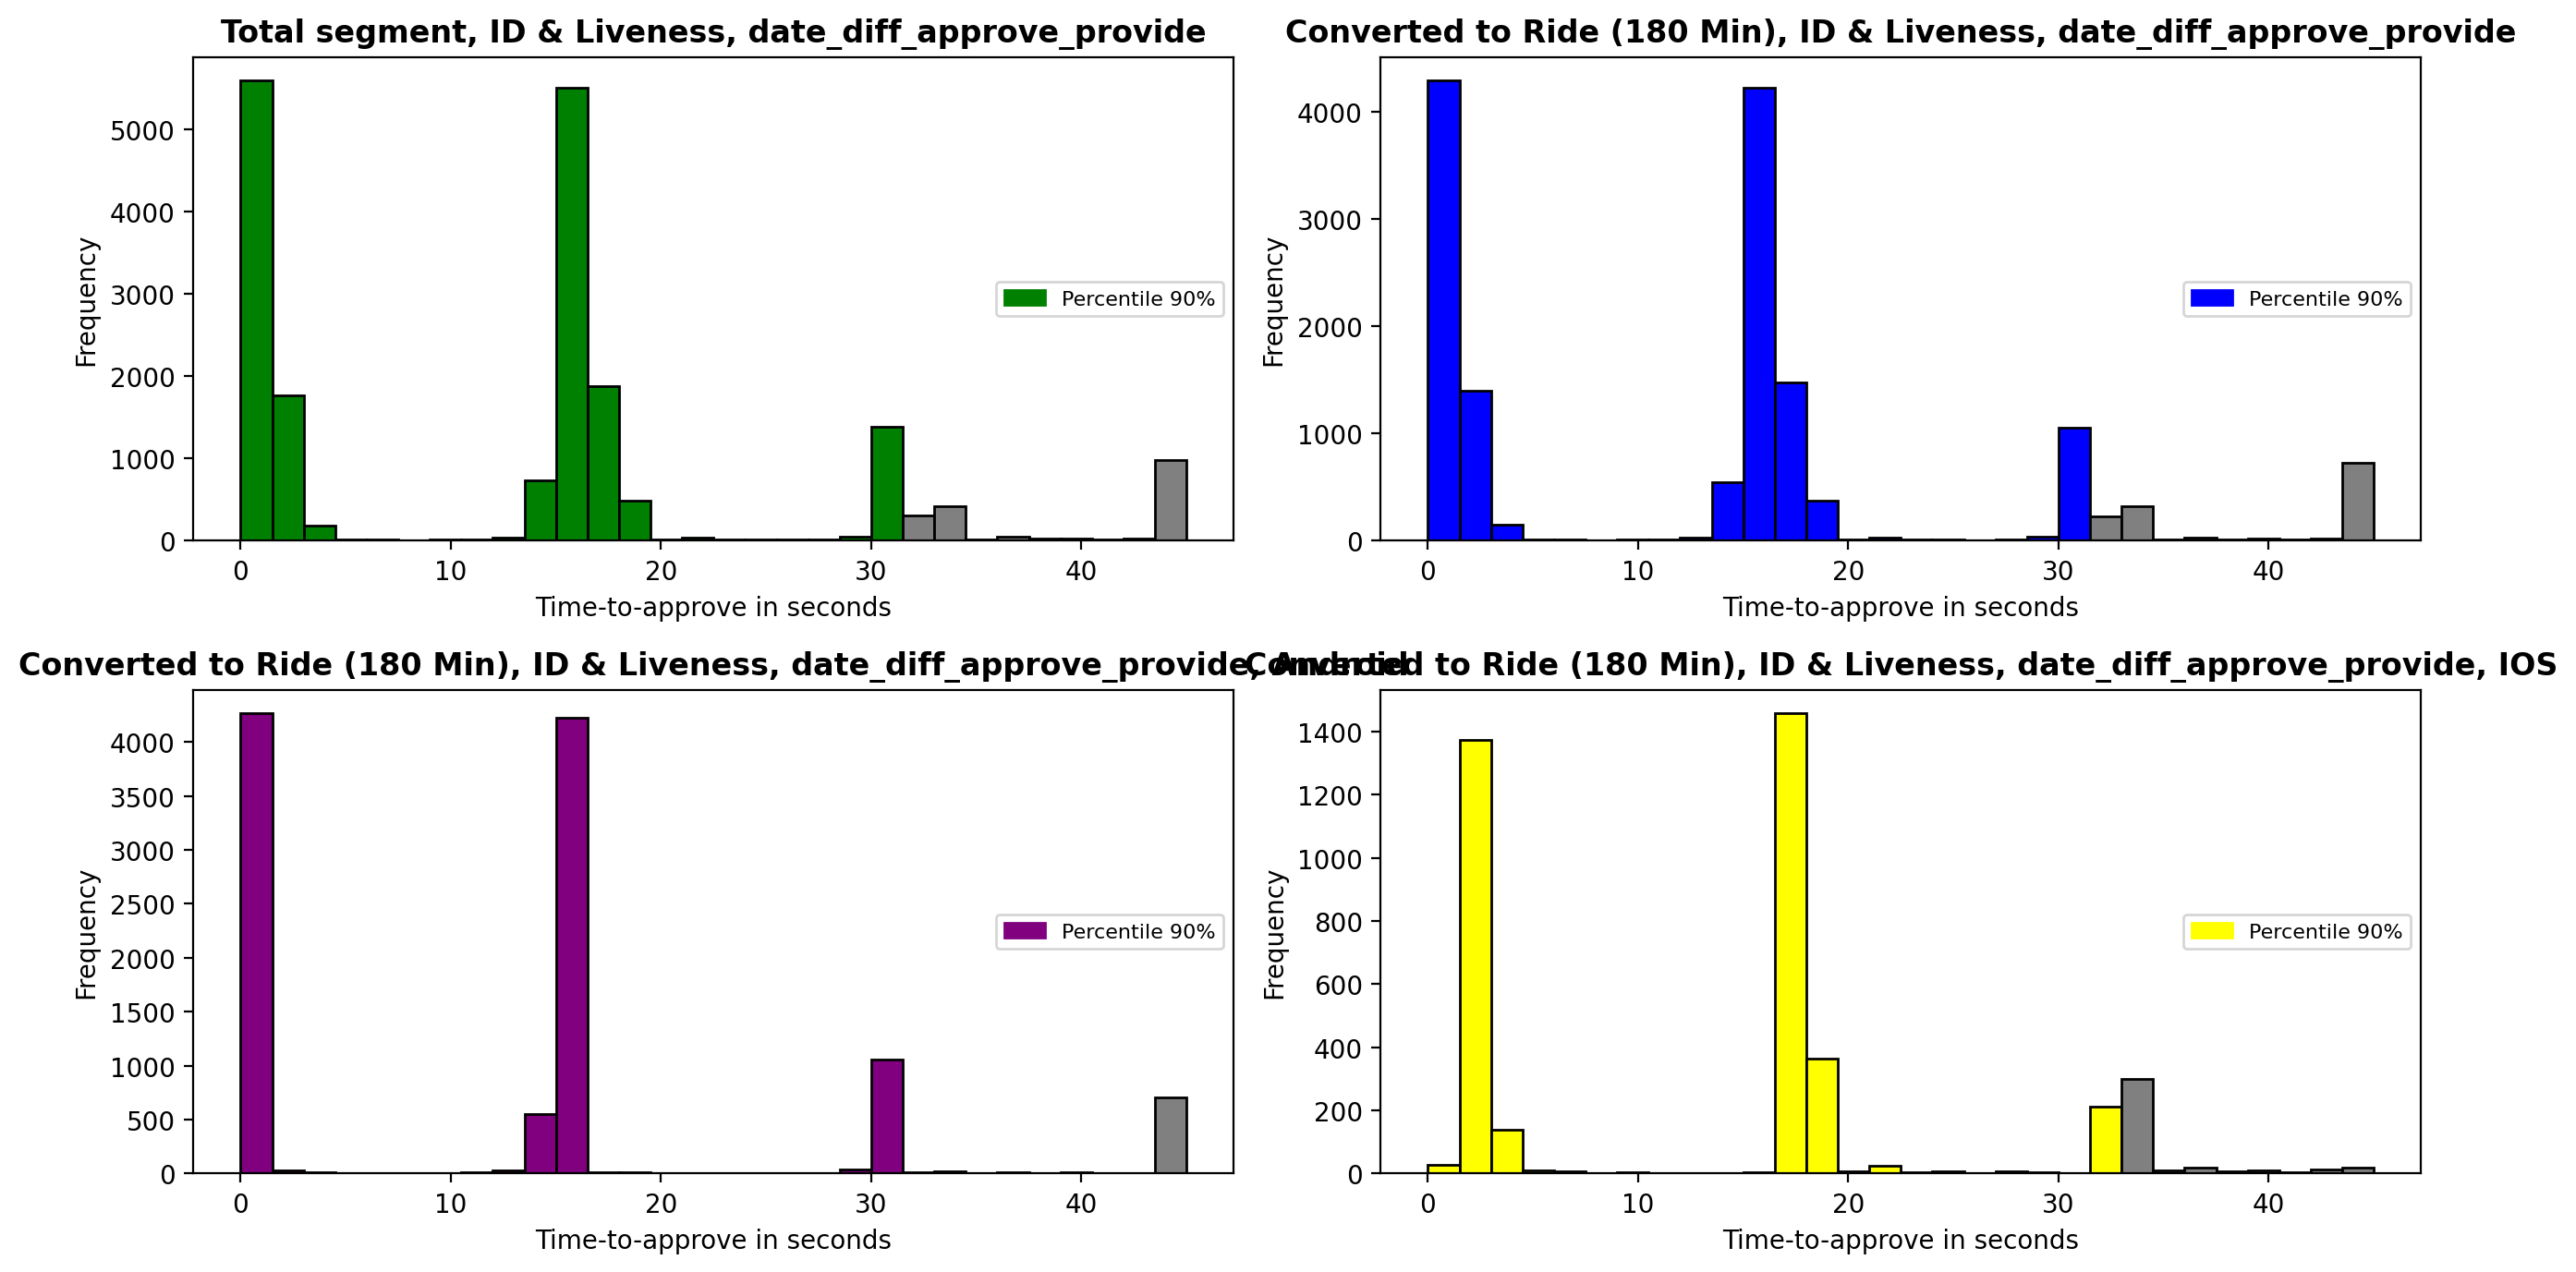

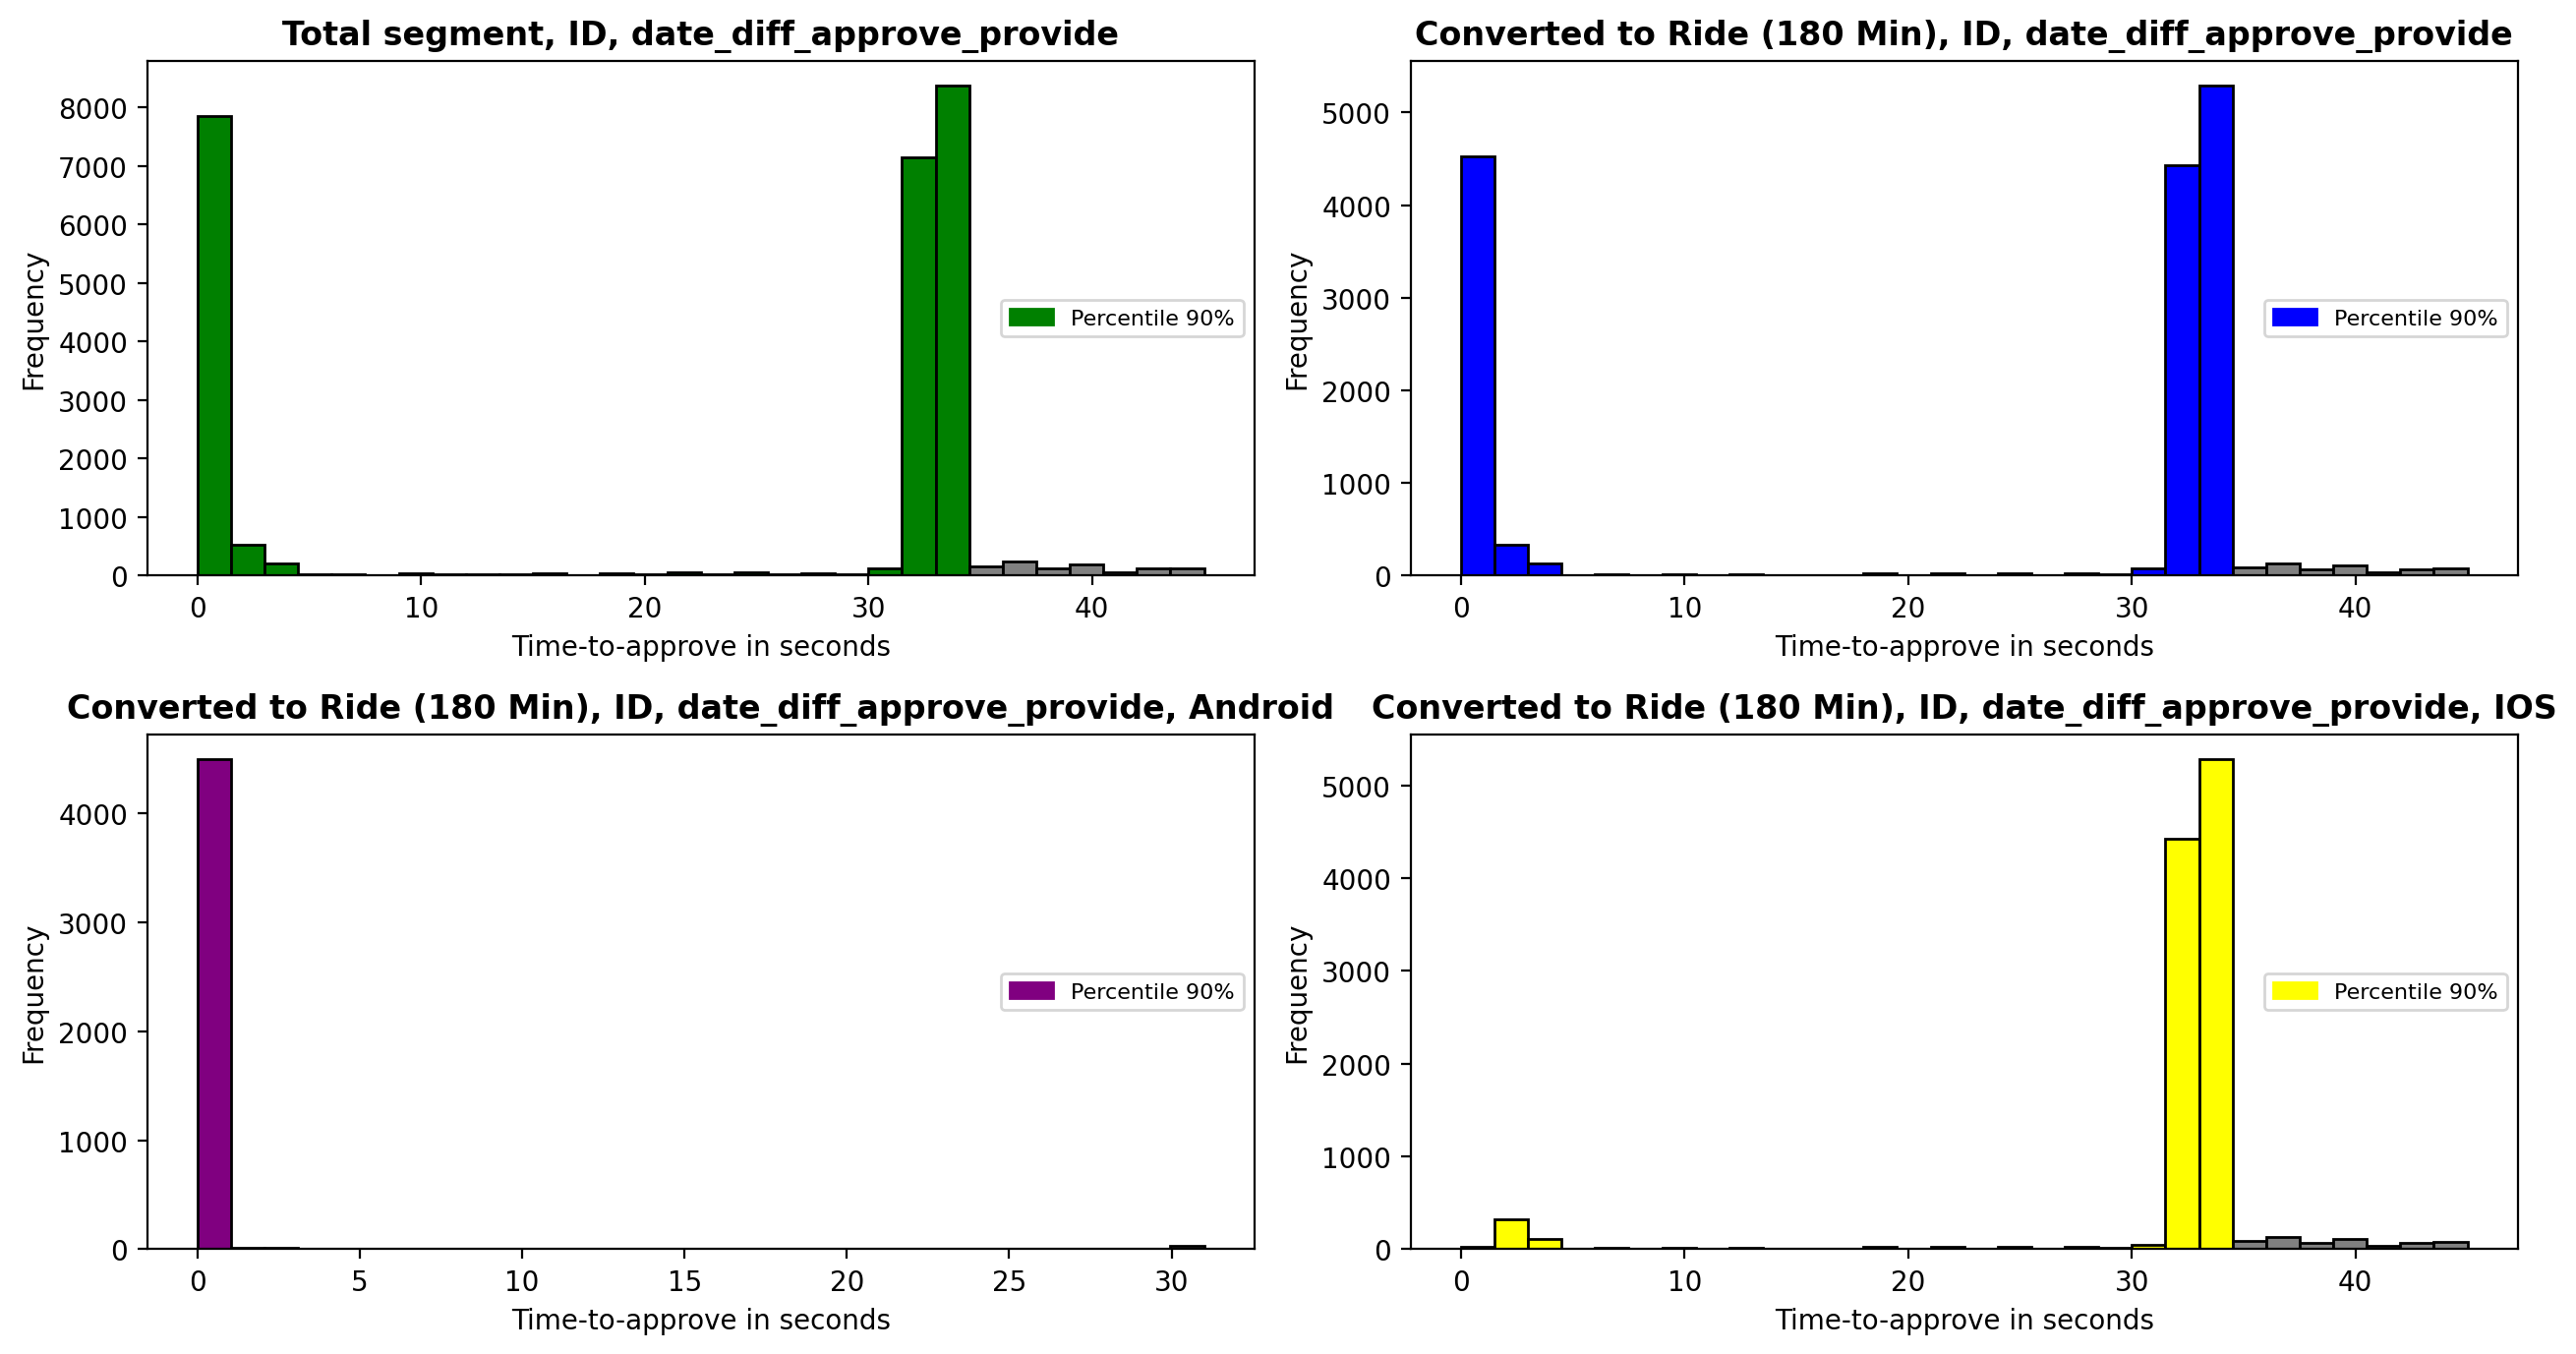

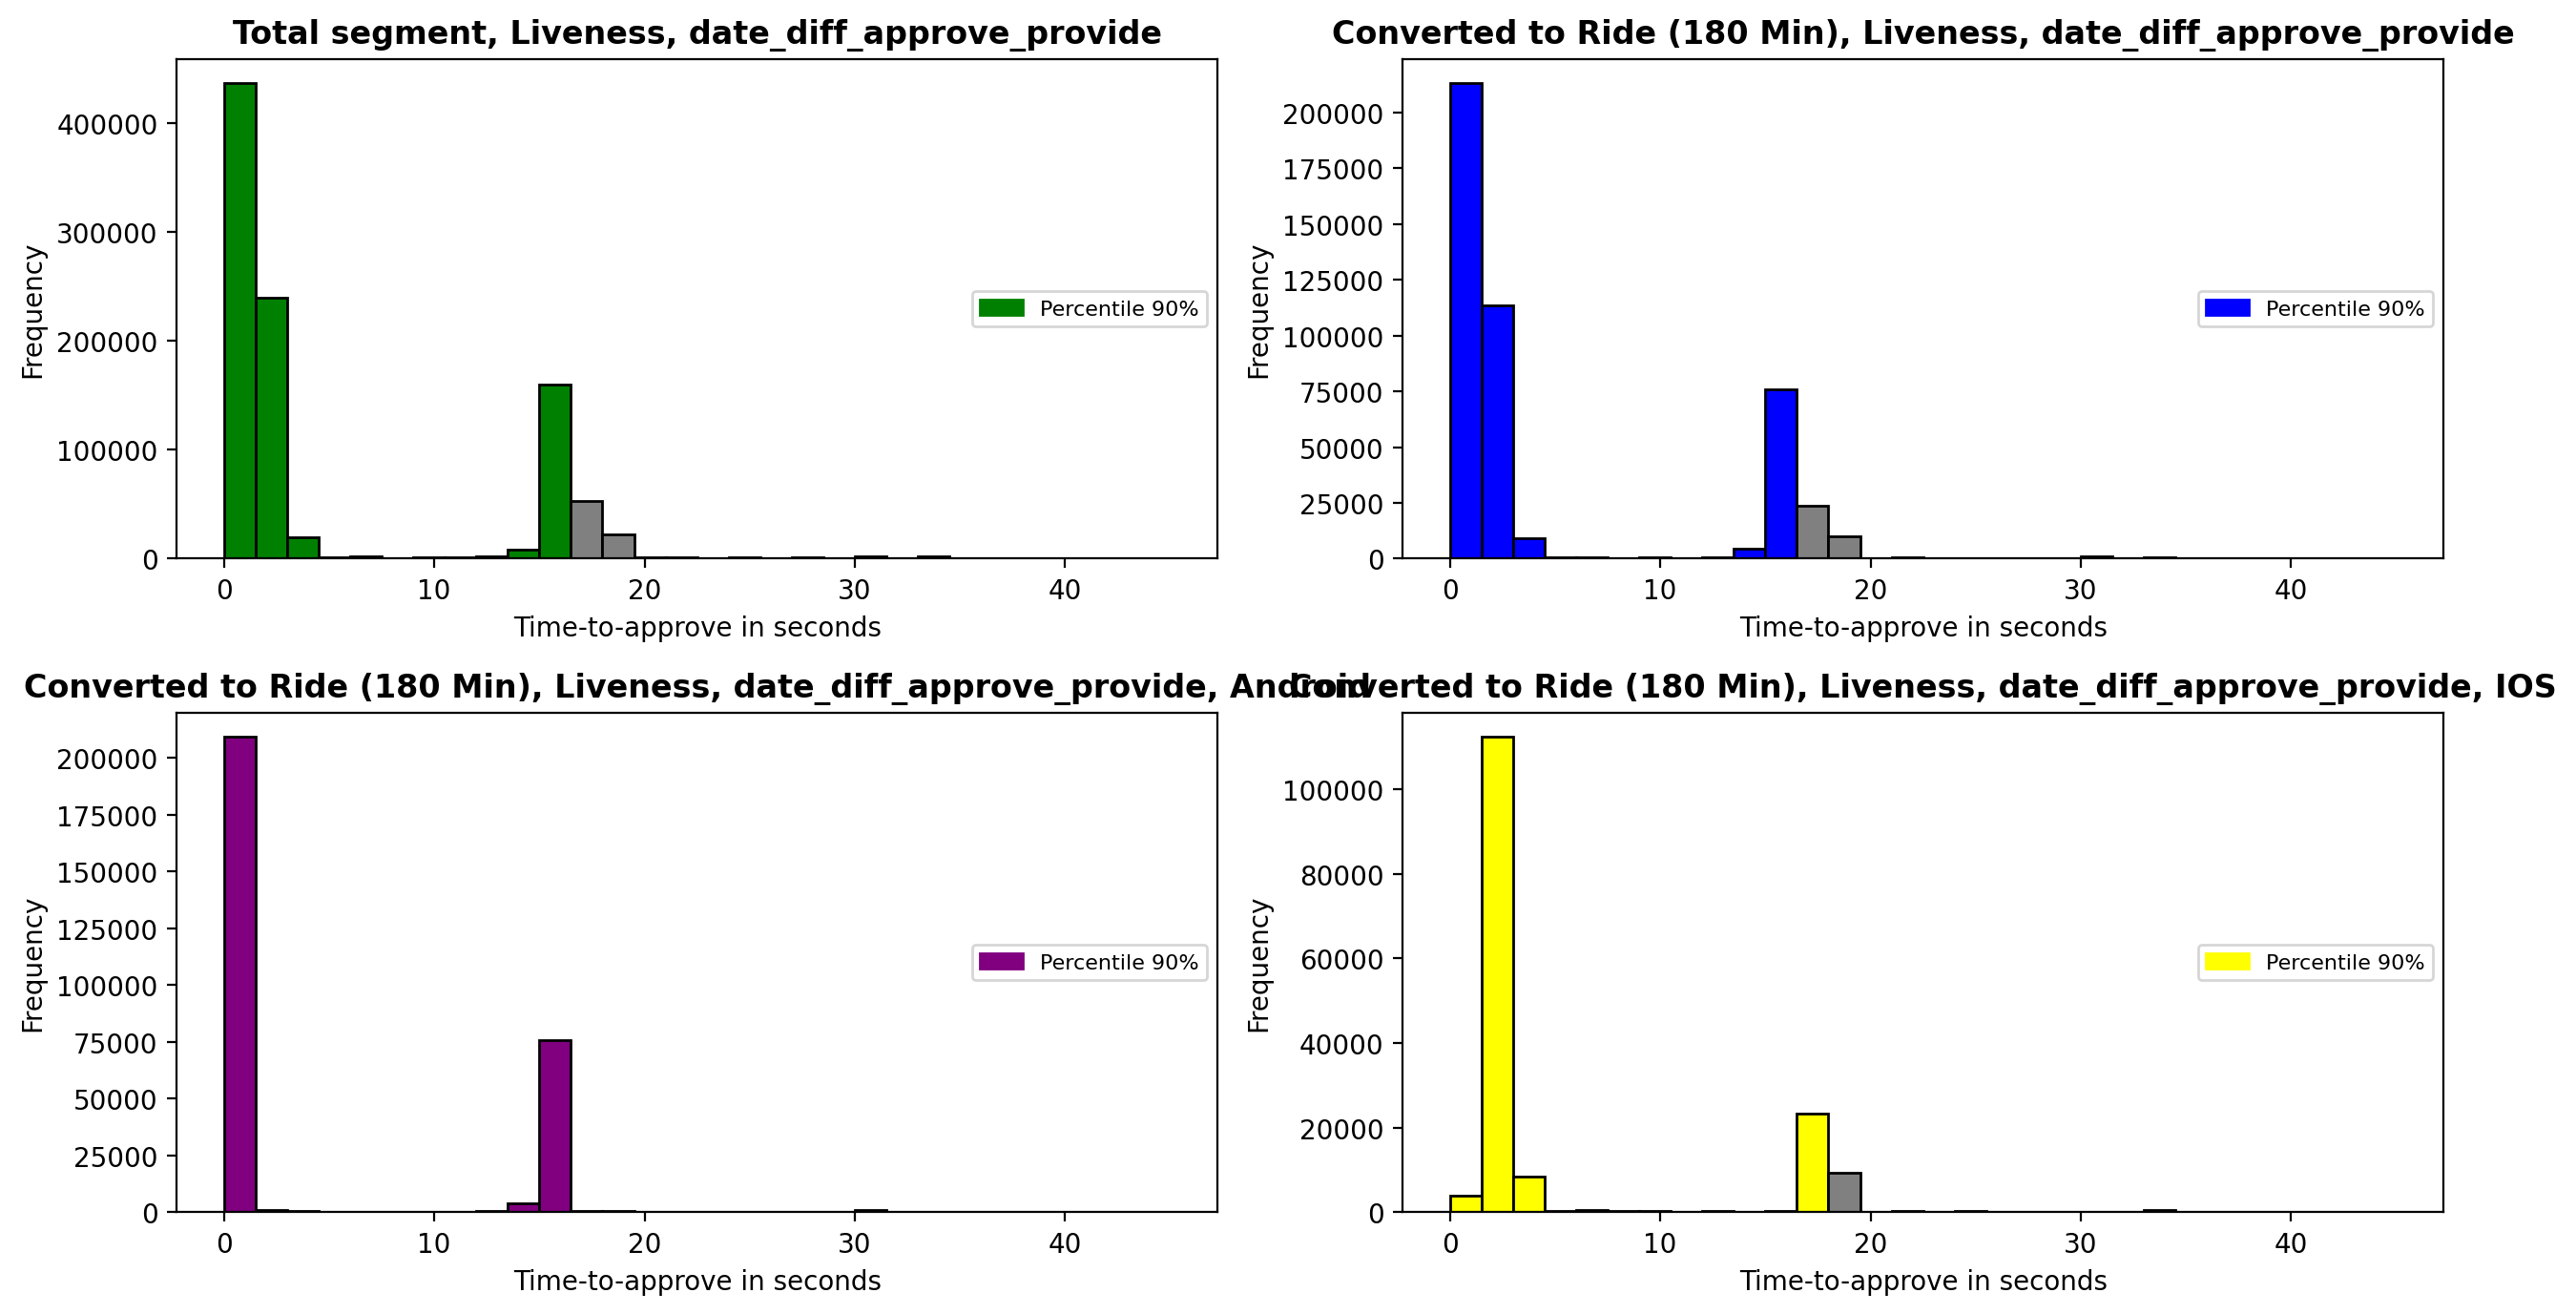

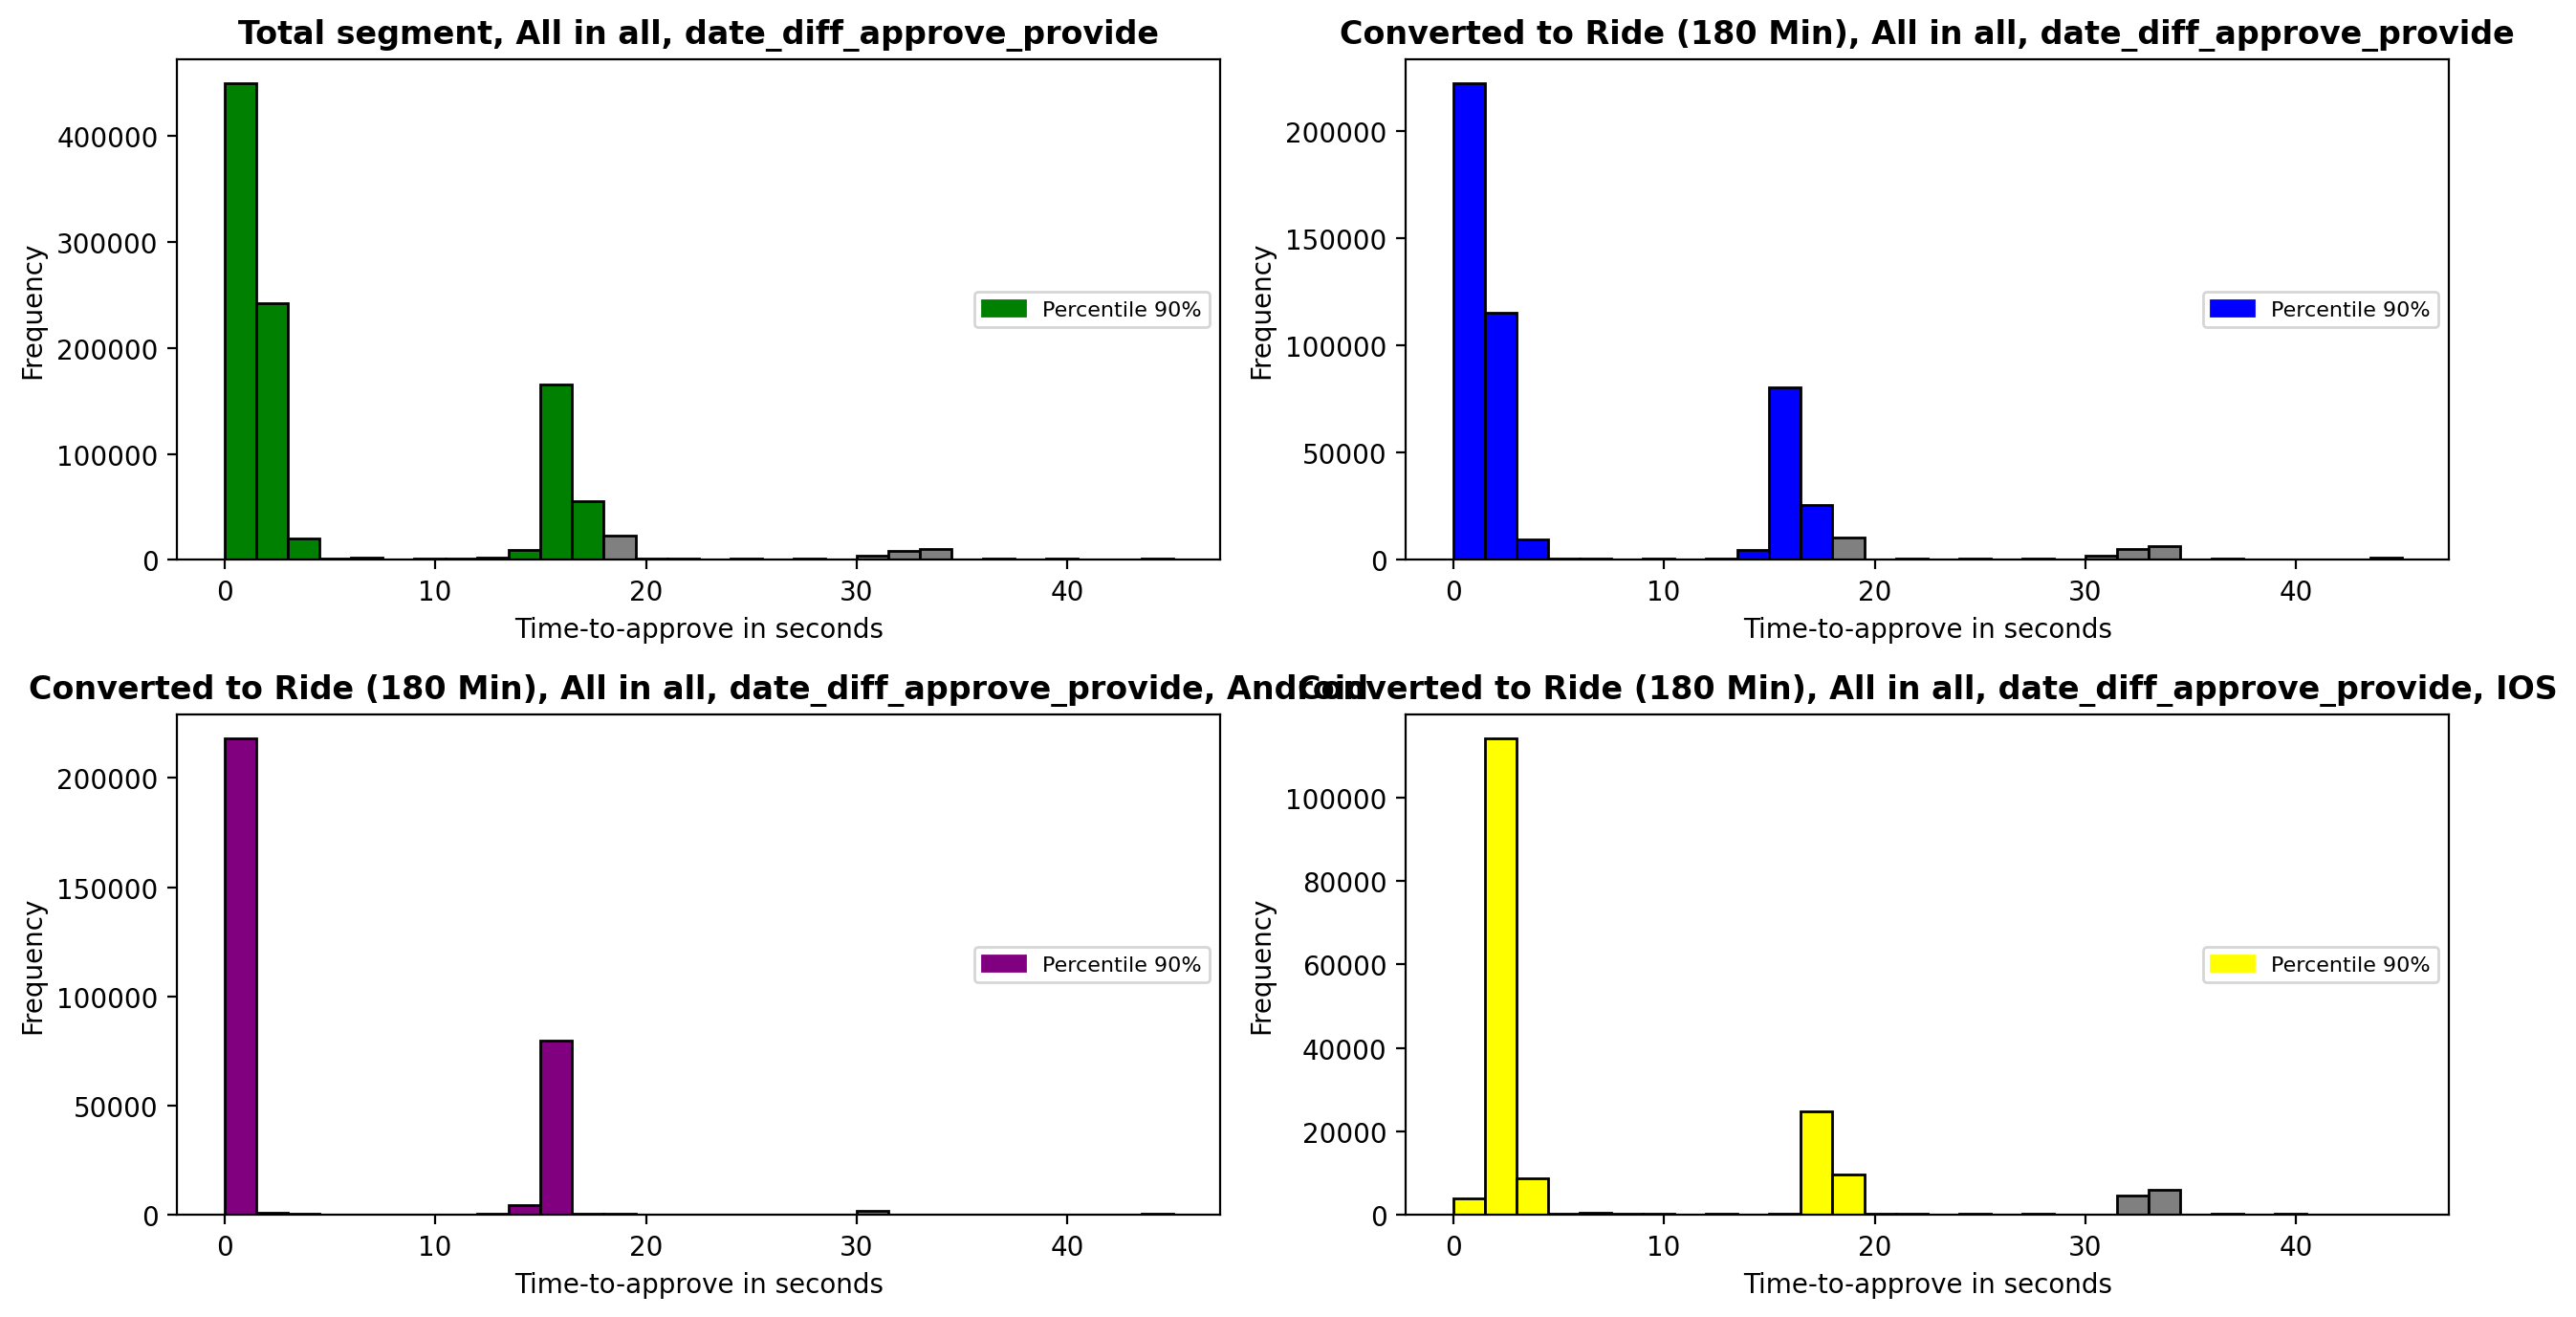

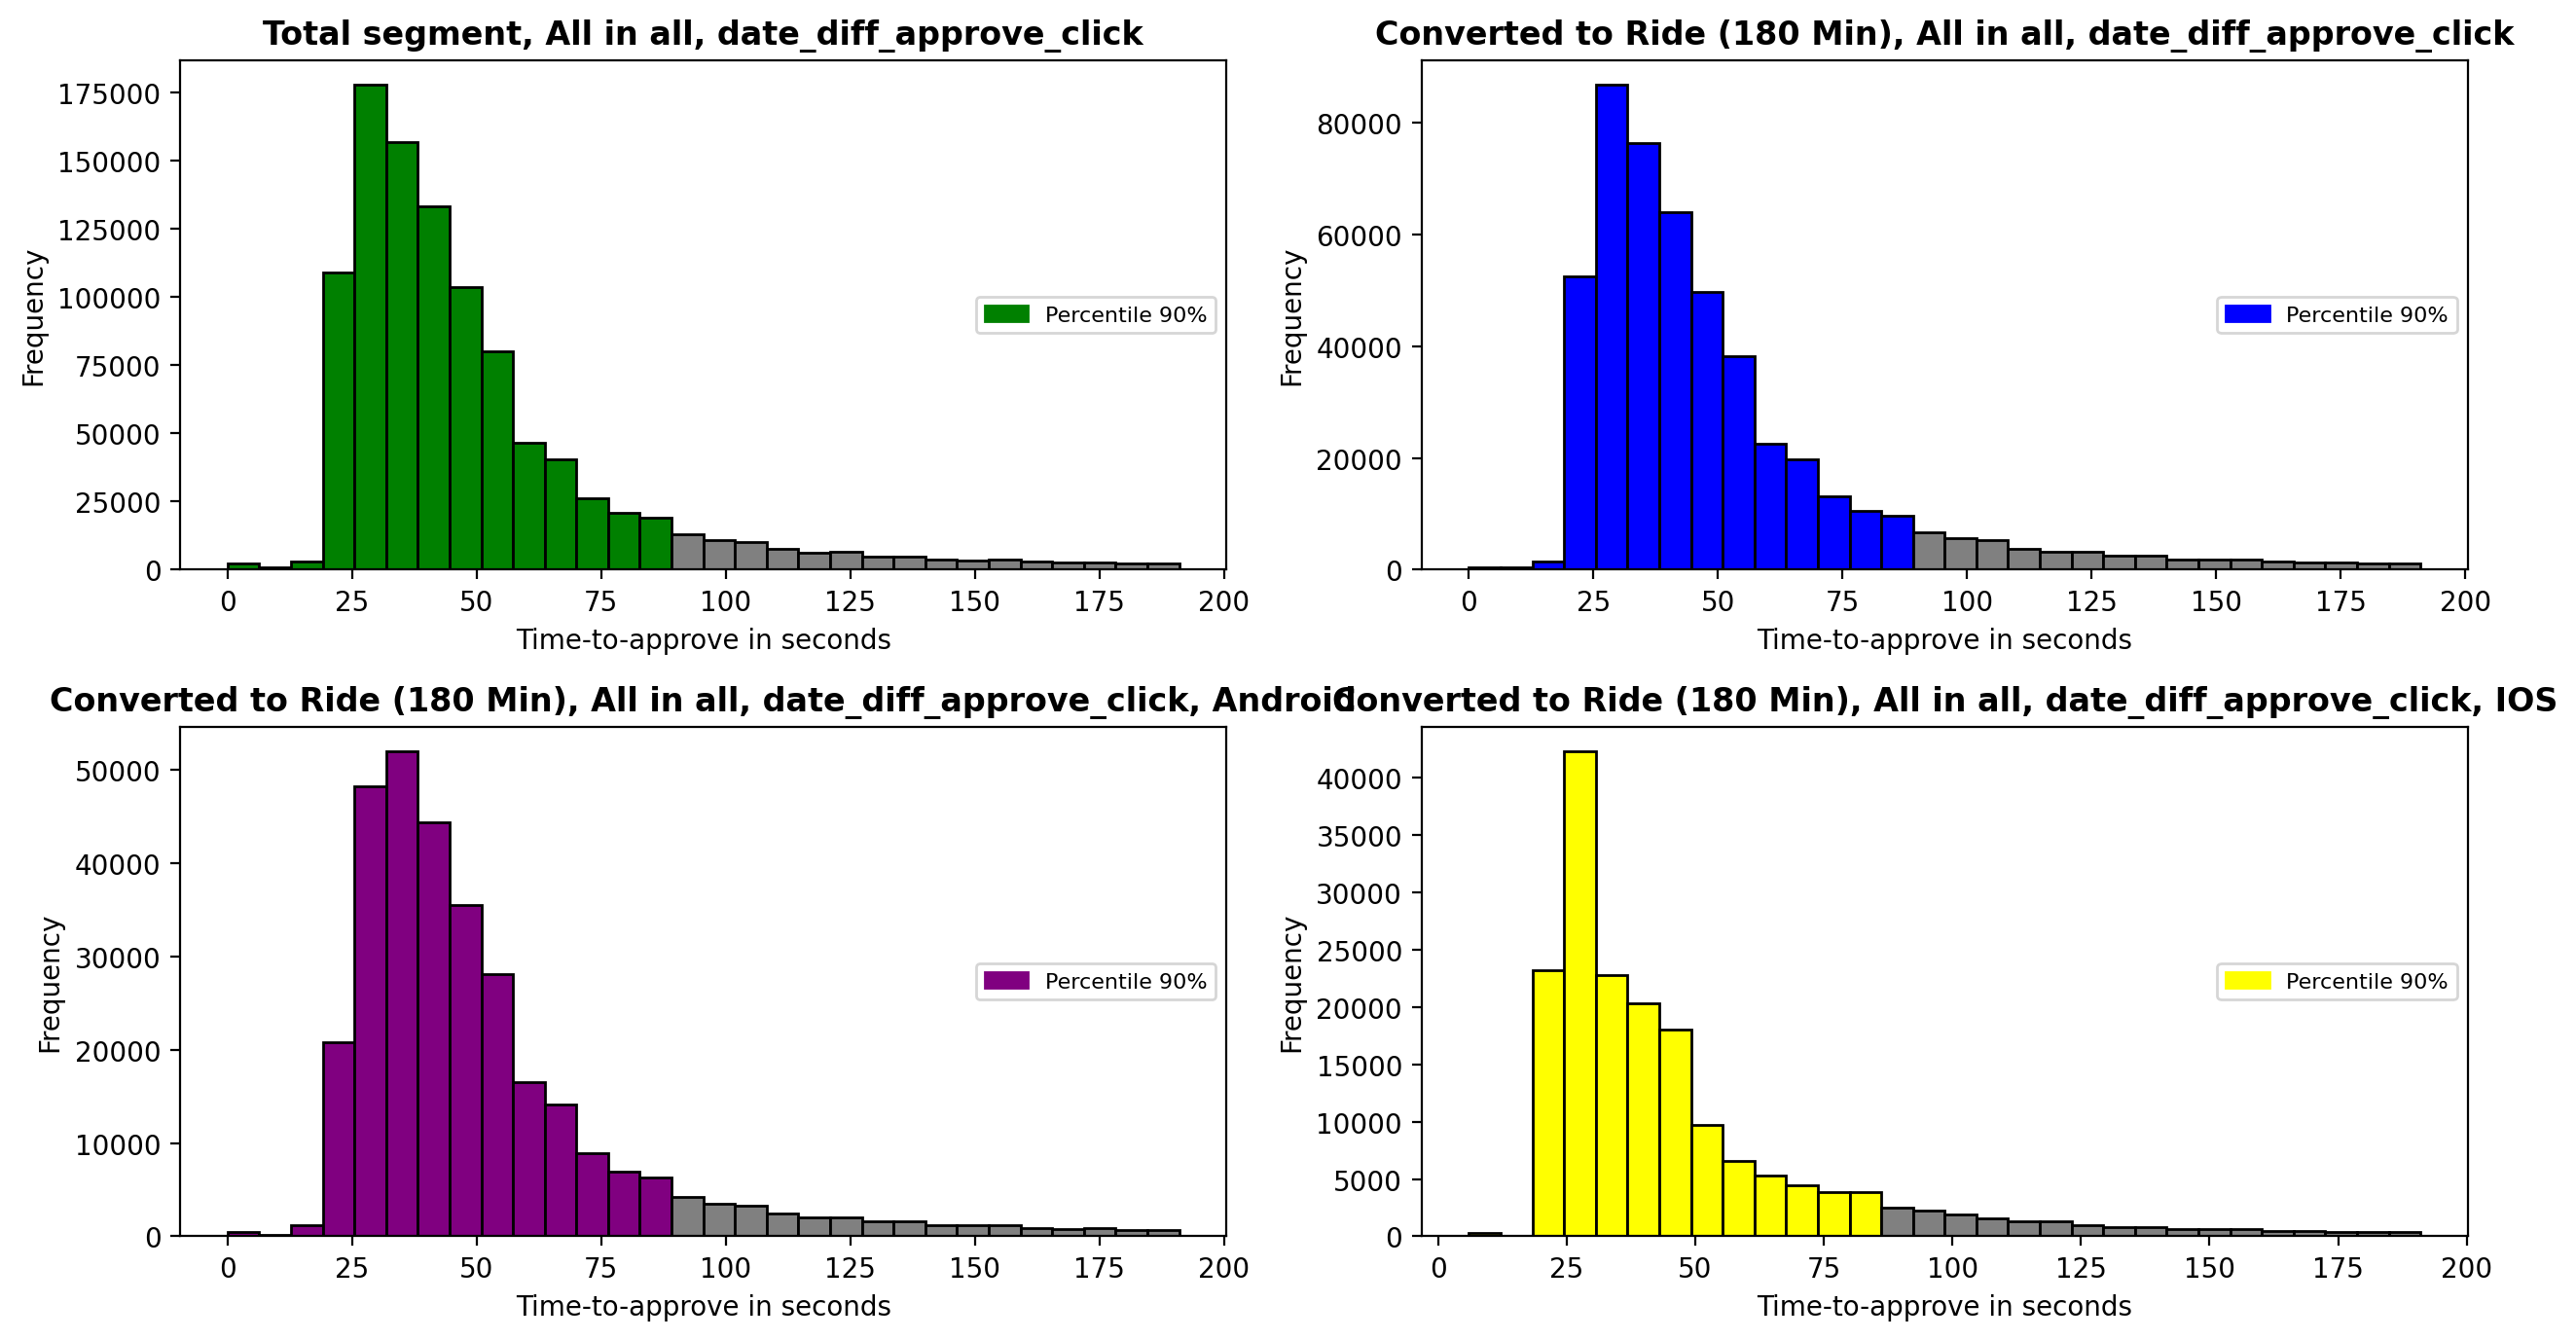

In [238]:
id_liveness = [4269, 5607, 4267]
id = [7173, 5901, 5905, 5910, 5913, 5916, 5920, 5934, 5928, 5907, 5911, 5921, 5933, 7167, 5899, 5919, 5927, 5930, 5946, 25958, 7170, 5914, 5924, 5908, 5931, 5918, 5922, 5909, 7171, 5929, 5904, 7174, 5945]
segment = ['ID & Liveness', 'ID', 'Liveness', 'All in all']

def draw_chart(data, metric):

    x_location = 30

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(13, 7))
    
    # Total view
    values, bins, patches = ax1.hist(data[f'{metric}'], bins=30, color='Grey', edgecolor='black')
    ax1.set_title(f'Total segment, {category}, {metric}', fontweight='bold')
    ax1.set_xlabel(f'Time-to-approve in seconds')
    ax1.set_ylabel(f'Frequency')

    percentile = np.percentile(data[f'{metric}'], 90)
    mean = data[f'{metric}'].mean()
    std = data[f'{metric}'].std()

    for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
        if left_edge <= percentile:
            patch.set_facecolor('Green')

    blue_patch = mpatches.Patch(color='Green', label='Percentile 90%') 
    ax1.legend(handles=[blue_patch], prop={'size': 8}, loc='center right')

    location = pd.cut(data[f'{metric}'], 30).value_counts().max()

    # ax1.text(x_location, location*0.9, f'Percentile 90% - {percentile:.2f} sec')
    # ax1.text(x_location, location*0.8, f'Mean - {mean:.2f} sec')
    # ax1.text(x_location, location*0.7, f'STD - {std:.2f} sec')

    # users with rides within 180 min upon check
    values, bins, patches = ax2.hist(data.query("has_ride == 1")[f'{metric}'], bins=30, color='Grey', edgecolor='black')
    ax2.set_title(f'Converted to Ride (180 Min), {category}, {metric}', fontweight='bold')
    ax2.set_xlabel(f'Time-to-approve in seconds')
    ax2.set_ylabel(f'Frequency')

    percentile = np.percentile(data.query("has_ride == 1")[f'{metric}'], 90)
    mean = data.query("has_ride == 1")[f'{metric}'].mean()
    std = data.query("has_ride == 1")[f'{metric}'].std()

    for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
        if left_edge <= percentile:
            patch.set_facecolor('Blue')
        
    blue_patch = mpatches.Patch(color='Blue', label='Percentile 90%') 
    ax2.legend(handles=[blue_patch], prop={'size': 8}, loc='center right')

    location = pd.cut(data.query("has_ride == 1")[f'{metric}'], 30).value_counts().max()

    # ax2.text(x_location , location*0.9, f'Percentile 90% - {percentile:.2f} sec')
    # ax2.text(x_location , location*0.8, f'Mean - {mean:.2f} sec')
    # ax2.text(x_location , location*0.7, f'STD - {std:.2f} sec')

    # Android 
    values, bins, patches = ax3.hist(data.query("has_ride == 1 and os_name == 'android'")[f'{metric}'], bins=30, color='Grey', edgecolor='black')
    ax3.set_title(f'Converted to Ride (180 Min), {category}, {metric}, Android', fontweight='bold')
    ax3.set_xlabel(f'Time-to-approve in seconds')
    ax3.set_ylabel(f'Frequency')

    percentile = np.percentile(data.query("has_ride == 1 and os_name == 'android'")[f'{metric}'], 90)
    mean = data.query("has_ride == 1 and os_name == 'android'")[f'{metric}'].mean()
    std = data.query("has_ride == 1 and os_name == 'android'")[f'{metric}'].std()

    for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
        if left_edge <= percentile:
            patch.set_facecolor('Purple')

    blue_patch = mpatches.Patch(color='Purple', label='Percentile 90%') 
    ax3.legend(handles=[blue_patch], prop={'size': 8}, loc='center right')

    location = pd.cut(data.query("has_ride == 1 and os_name == 'android'")[f'{metric}'], 30).value_counts().max()

    # ax3.text(x_location , location*0.9, f'Percentile 90% - {percentile:.2f} sec')
    # ax3.text(x_location , location*0.75, f'Mean - {mean:.2f} sec')
    # ax3.text(x_location , location*0.60, f'STD - {std:.2f} sec')

    # IOS
    values, bins, patches = ax4.hist(data.query("has_ride == 1 and os_name == 'ios'")[f'{metric}'], bins=30, color='Grey', edgecolor='black')
    ax4.set_title(f'Converted to Ride (180 Min), {category}, {metric}, IOS', fontweight='bold')
    ax4.set_xlabel(f'Time-to-approve in seconds')
    ax4.set_ylabel(f'Frequency')

    percentile = np.percentile(data.query("has_ride == 1 and os_name == 'ios'")[f'{metric}'], 90)
    mean = data.query("has_ride == 1 and os_name == 'ios'")[f'{metric}'].mean()
    std = data.query("has_ride == 1 and os_name == 'ios'")[f'{metric}'].std()

    for patch, left_edge, right_edge in zip(patches, bins[:-1], bins[1:]):
        if left_edge <= percentile:
            patch.set_facecolor('Yellow')

    blue_patch = mpatches.Patch(color='Yellow', label='Percentile 90%') 
    ax4.legend(handles=[blue_patch], prop={'size': 8}, loc='center right')

    location = pd.cut(data.query("has_ride == 1 and os_name == 'ios'")[f'{metric}'], 30).value_counts().max()

    # ax4.text(x_location , location*0.9, f'Percentile 90% - {percentile:.2f} sec')
    # ax4.text(x_location , location*0.75, f'Mean - {mean:.2f} sec')
    # ax4.text(x_location , location*0.60, f'STD - {std:.2f} sec')
    
    plt.tight_layout()
    plt.show()


for category in segment:
    if category == 'ID & Liveness':
        draw_chart(df_checks[df_checks['city_id'].isin(id_liveness)], 'date_diff_approve_provide')
    elif category == 'ID':
        draw_chart(df_checks[df_checks['city_id'].isin(id)], 'date_diff_approve_provide')
    elif category == 'Liveness':
        draw_chart(df_checks[(~df_checks['city_id'].isin(id_liveness))&(~df_checks['city_id'].isin(id))], 'date_diff_approve_provide')
    else:
        draw_chart(df_checks, 'date_diff_approve_provide')
        draw_chart(df_checks, 'date_diff_approve_click')
    